In [1]:
import ray
import numpy as np
import pandas as pd
import yfinance as yf
import pandas_ta as ta

from ray import tune
from ray.tune.registry import register_env

import tensortrade.env.default as default

from tensortrade.feed.core import DataFeed, Stream
from tensortrade.oms.exchanges import Exchange
from tensortrade.oms.services.execution.simulated import execute_order
from tensortrade.oms.wallets import Wallet, Portfolio
from tensortrade.env.default.rewards import TensorTradeRewardScheme
from tensortrade.feed.core import Stream, DataFeed

from gym.spaces import Discrete
from tensortrade.env.default.actions import TensorTradeActionScheme
from tensortrade.env.generic import ActionScheme, TradingEnv
from tensortrade.core import Clock
from tensortrade.oms.instruments import ExchangePair, Instrument
from tensortrade.oms.wallets import Portfolio
from tensortrade.oms.orders import (
    Order,
    proportion_order,
    TradeSide,
    TradeType
)

import matplotlib.pyplot as plt

from tensortrade.env.generic import Renderer

import ray.rllib.agents.ppo as ppo

In [2]:
BRL = Instrument("BRL", 2, "Brazilian Currency")
ASSET = Instrument("ASSET", 2, "Asset")

In [3]:
class BSH(TensorTradeActionScheme):
    """The ActionScheme interprets and applies the agent’s actions to the environment."""

    registered_name = "bsh"

    def __init__(self, cash: 'Wallet', asset: 'Wallet'):
        super().__init__()
        self.cash = cash
        self.asset = asset

        self.listeners = []
        self.action = 0

    @property
    def action_space(self):
        return Discrete(2)

    def attach(self, listener):
        self.listeners += [listener]
        return self

    def get_orders(self,
                   action: int,
                   portfolio: 'Portfolio'):
        
        order = None

        if abs(action - self.action) > 0:
            src = self.cash if self.action == 0 else self.asset
            tgt = self.asset if self.action == 0 else self.cash

            if src == self.cash:
                # Calculates proportional order size (n lots of 100 shares)
                lot_size = 100.00
                current_price = float(portfolio.exchange_pairs[0].price)
                source_balance = src.balance.as_float()

                qtd_assets = source_balance / (lot_size * current_price)

                num_shares = int(qtd_assets - (qtd_assets % 10)) * lot_size

                proportional_lot_size = (num_shares * current_price) / source_balance
            else:
                proportional_lot_size = 1.0

#             print('--' * 50)
#             if src == self.cash:
#                 print ('CASH TO ASSET')
#                 print('Source Balance: ', src.balance.as_float())
#                 print('Target Balance: ', tgt.balance.as_float())
#                 print('Proportional Lot Size', proportional_lot_size)
#                 print('Current Price: ', float(portfolio.exchange_pairs[0].price))
#                 print('# Shares: ', num_shares)
#                 print('Current Price x # Shares: ', num_shares * float(portfolio.exchange_pairs[0].price))
#             else:
#                 print ('ASSET TO CASH')
#                 print('Source Balance: ', src.balance.as_float())
#                 print('Target Balance: ', tgt.balance.as_float())
#                 print('Proportional Lot Size', proportional_lot_size)

#             print('--' * 50)

            order = proportion_order(portfolio, src, tgt, proportional_lot_size)

            self.action = action

        for listener in self.listeners:
            listener.on_action(action)

        return [order]

    def reset(self):
        super().reset()
        self.action = 0

In [4]:
class PBR(TensorTradeRewardScheme):

    """ Position-based reward scheme (PBR).
    
    The RewardScheme computes the reward for 
    each time step based on the agent’s performance.
    """
    
    registered_name = "pbr"

    def __init__(self, price: 'Stream'):
        super().__init__()
        self.position = -1

        r = Stream.sensor(price, lambda p: p.value, dtype="float").diff()
        position = Stream.sensor(self, lambda rs: rs.position, dtype="float")

        reward = (r * position).fillna(0).rename("reward")

        self.feed = DataFeed([reward])
        self.feed.compile()

    def on_action(self, action: int):
        self.position = -1 if action == 0 else 1

    def get_reward(self, portfolio: 'Portfolio'):
        return self.feed.next()["reward"]

    def reset(self):
        self.position = -1
        self.feed.reset()

In [5]:
class PositionChangeChart(Renderer):
    """The Renderer renders a view of the environment and interactions."""
    
    def __init__(self, color: str = "orange"):
        self.color = "orange"

    def render(self, env, **kwargs):
        # The Observer generates the next observation for the agent.
        history = pd.DataFrame(env.observer.renderer_history)

        actions = list(history.action)
        p = list(history.price)

        buy = {}
        sell = {}

        for i in range(len(actions) - 1):
            a1 = actions[i]
            a2 = actions[i + 1]

            if a1 != a2:
                if a1 == 0 and a2 == 1:
                    buy[i] = p[i]
                else:
                    sell[i] = p[i]

        buy = pd.Series(buy)
        sell = pd.Series(sell)

        fig, axs = plt.subplots(1, 2, figsize=(15, 5))

        fig.suptitle("Performance")

        axs[0].plot(np.arange(len(p)), p, label="price", color=self.color)
        axs[0].scatter(buy.index, buy.values, marker="v", color="red") # BUY
        axs[0].scatter(sell.index, sell.values, marker="^", color="green") # SELL
        axs[0].set_title("Trading Chart")
        axs[0].legend(['Price', 'Buys', 'Sells'])

        performance_df = pd.DataFrame().from_dict(env.action_scheme.portfolio.performance, orient='index')
        performance_df.plot(ax=axs[1])
        axs[1].set_title("Net Worth")

        plt.show()

---

### Train

Now in order to use our custom environment in ray we must first write a function that creates an instance of the TradingEnv from a configuration dictionary.

In [6]:
def create_training_env(config):
    """Creates Trading Environment. """
    
    ticker = 'PETR4'

    # PRICES
    y = yf.download(f'{ticker}.SA', start='2021-01-01', end='2022-01-01')['Adj Close'].dropna().values
    p = Stream.source(y, dtype="float").rename("BRL-ASSET")
    
    b3 = Exchange("B3", service=execute_order)(p)

    # Portfolio
    cash = Wallet(b3, 100000 * BRL) # Money
    asset = Wallet(b3, 0 * ASSET) # Stocks
    
    portfolio = Portfolio(BRL, [cash, asset])

    # Data
    feed = DataFeed([
        p,
        p.rolling(window=10).mean().rename("fast"),
        p.rolling(window=50).mean().rename("medium"),
        p.rolling(window=100).mean().rename("slow"),
        p.log().diff().fillna(0).rename("lr")
    ])
    
    # Reward
    reward_scheme = PBR(price=p)
    
    # Actions
    action_scheme = BSH(
        cash=cash,
        asset=asset
    ).attach(reward_scheme)
    
    # Visualization
    renderer_feed = DataFeed([
        Stream.source(list(yf.download(f'{ticker}.SA', start='2021-01-01', end='2022-01-01').index)).rename("date"),
        Stream.source(y, dtype="float").rename("price"),
        Stream.sensor(action_scheme, lambda s: s.action, dtype="float").rename("action")
    ])

    # Environment
    environment = default.create(
        feed=feed,
        portfolio=portfolio,
        action_scheme=action_scheme,
        reward_scheme=reward_scheme,
        renderer_feed=renderer_feed,
        renderer=PositionChangeChart(),
        window_size=config["window_size"],
        max_allowed_loss=0.6
    )
    
    return environment

register_env("TradingEnv", create_training_env)

---

Now that the environment is registered we can run the training algorithm using the Proximal Policy Optimization (PPO) algorithm implemented in rllib.

In [7]:
window_size = 20

analysis = tune.run(
    "PPO",
    stop={
      "episode_reward_mean": 2.5
    },
    config={
        "env": "TradingEnv",
        "env_config": {
            "window_size": window_size
        },
        "log_level": "DEBUG",
        "framework": "tf2",
        "ignore_worker_failures": True,
        "num_workers": 1,
        "num_gpus": 1,
        "clip_rewards": True,
        "lr": 8e-6,
        "lr_schedule": [
            [0, 1e-1],
            [int(1e2), 1e-2],
            [int(1e3), 1e-3],
            [int(1e4), 1e-4],
            [int(1e5), 1e-5],
            [int(1e6), 1e-6],
            [int(1e7), 1e-7]
        ],
        "gamma": 0,
        "observation_filter": "MeanStdFilter",
        "lambda": 0.72,
        "vf_loss_coeff": 0.5,
        "entropy_coeff": 0.01
    },
    checkpoint_at_end=True
)

2022-03-04 01:15:45,911	INFO services.py:1338 -- View the Ray dashboard at http://127.0.0.1:8265
2022-03-04 01:15:57,856	ERROR syncer.py:111 -- Log sync requires rsync to be installed.
 pid=15680) 2022-03-04 01:16:09,221	INFO trainer.py:712 -- Executing eagerly (framework='tf2'), with eager_tracing=False. For production workloads, make sure to set `eager_tracing=True` in order to match the speed of tf-static-graph (framework='tf'). For debugging purposes, `eager_tracing=False` is the best choice.


[*********************100%***********************]  1 of 1 completed


 pid=3748) 2022-03-04 01:16:15,149	INFO rollout_worker.py:1705 -- Validating sub-env at vector index=0 ... (ok)


[*********************100%***********************]  1 of 1 completed


 pid=3748) 2022-03-04 01:16:16,119	DEBUG rollout_worker.py:1534 -- Creating policy for default_policy
 pid=3748) 2022-03-04 01:16:16,124	DEBUG catalog.py:706 -- Created preprocessor <ray.rllib.models.preprocessors.NoPreprocessor object at 0x000001538BB38190>: Box([[-inf -inf -inf -inf -inf]
 pid=3748)  [-inf -inf -inf -inf -inf]
 pid=3748)  [-inf -inf -inf -inf -inf]
 pid=3748)  [-inf -inf -inf -inf -inf]
 pid=3748)  [-inf -inf -inf -inf -inf]
 pid=3748)  [-inf -inf -inf -inf -inf]
 pid=3748)  [-inf -inf -inf -inf -inf]
 pid=3748)  [-inf -inf -inf -inf -inf]
 pid=3748)  [-inf -inf -inf -inf -inf]
 pid=3748)  [-inf -inf -inf -inf -inf]
 pid=3748)  [-inf -inf -inf -inf -inf]
 pid=3748)  [-inf -inf -inf -inf -inf]
 pid=3748)  [-inf -inf -inf -inf -inf]
 pid=3748)  [-inf -inf -inf -inf -inf]
 pid=3748)  [-inf -inf -inf -inf -inf]
 pid=3748)  [-inf -inf -inf -inf -inf]
 pid=3748)  [-inf -inf -inf -inf -inf]
 pid=3748)  [-inf -inf -inf -inf -inf]
 pid=3748)  [-inf -inf -inf -inf -inf]
 pid=3

Trial name,status,loc
PPO_TradingEnv_caae3_00000,RUNNING,127.0.0.1:15680


 pid=15680) 2022-03-04 01:16:23,896	INFO rollout_worker.py:1555 -- Built policy map: {}
 pid=15680) 2022-03-04 01:16:23,896	INFO rollout_worker.py:1556 -- Built preprocessor map: {'default_policy': <ray.rllib.models.preprocessors.NoPreprocessor object at 0x000001C8757A6B80>}
 pid=15680) 2022-03-04 01:16:23,896	INFO rollout_worker.py:618 -- Built filter map: {'default_policy': MeanStdFilter((20, 5), True, True, None, (n=0, mean_mean=0.0, mean_std=0.0), (n=0, mean_mean=0.0, mean_std=0.0))}
 pid=15680) 2022-03-04 01:16:23,897	DEBUG rollout_worker.py:728 -- Created rollout worker with env None (None), policies {}
 pid=15680) 2022-03-04 01:16:23,904	INFO trainable.py:124 -- Trainable.setup took 15.944 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
 pid=15680) 2022-03-04 01:16:23,905	WARNING util.py:57 -- Install gputil for GPU system monitoring.
 pid=3748) 2022-03-04 01:16:24,712	INFO rollout_worker.py:754 -- Generati

Trial name,status,loc
PPO_TradingEnv_caae3_00000,RUNNING,127.0.0.1:15680


 pid=3748) 2022-03-04 01:16:26,217	INFO simple_list_collector.py:781 -- Trajectory fragment after postprocess_trajectory():
 pid=3748) 
 pid=3748) { 'agent0': { 'action_dist_inputs': np.ndarray((200, 2), dtype=float32, min=-0.021, max=0.011, mean=-0.004),
 pid=3748)               'action_logp': np.ndarray((200,), dtype=float32, min=-0.701, max=-0.682, mean=-0.693),
 pid=3748)               'actions': np.ndarray((200,), dtype=int64, min=0.0, max=1.0, mean=0.515),
 pid=3748)               'advantages': np.ndarray((200,), dtype=float32, min=-1.014, max=1.008, mean=-0.091),
 pid=3748)               'agent_index': np.ndarray((200,), dtype=int32, min=0.0, max=0.0, mean=0.0),
 pid=3748)               'dones': np.ndarray((200,), dtype=bool, min=0.0, max=0.0, mean=0.0),
 pid=3748)               'eps_id': np.ndarray((200,), dtype=int32, min=1391001689.0, max=1391001689.0, mean=1391001689.0),
 pid=3748)               'infos': np.ndarray((200,), dtype=object, head={'step': 1, 'net_worth': 100000.0

Trial name,status,loc
PPO_TradingEnv_caae3_00000,RUNNING,127.0.0.1:15680


Trial name,status,loc
PPO_TradingEnv_caae3_00000,RUNNING,127.0.0.1:15680


Trial name,status,loc
PPO_TradingEnv_caae3_00000,RUNNING,127.0.0.1:15680


Trial name,status,loc
PPO_TradingEnv_caae3_00000,RUNNING,127.0.0.1:15680


Trial name,status,loc
PPO_TradingEnv_caae3_00000,RUNNING,127.0.0.1:15680


 pid=15680) 2022-03-04 01:16:54,047	WARNING deprecation.py:45 -- DeprecationWarning: `_get_slice_indices` has been deprecated. This will raise an error in the future!
 pid=15680) 2022-03-04 01:16:54,047	WARNING deprecation.py:45 -- DeprecationWarning: `slice` has been deprecated. Use `SampleBatch[start:stop]` instead. This will raise an error in the future!
 pid=15680) 2022-03-04 01:16:54,048	INFO rollout_worker.py:836 -- Training on concatenated sample batches:
 pid=15680) 
 pid=15680) { 'count': 128,
 pid=15680)   'policy_batches': { 'default_policy': { 'action_dist_inputs': np.ndarray((128, 2), dtype=float32, min=-0.014, max=0.015, mean=-0.002),
 pid=15680)                                           'action_logp': np.ndarray((128,), dtype=float32, min=-0.7, max=-0.687, mean=-0.693),
 pid=15680)                                           'actions': np.ndarray((128,), dtype=int64, min=0.0, max=1.0, mean=0.508),
 pid=15680)                                           'advantages': np.ndarr

Trial name,status,loc
PPO_TradingEnv_caae3_00000,RUNNING,127.0.0.1:15680


Trial name,status,loc
PPO_TradingEnv_caae3_00000,RUNNING,127.0.0.1:15680


Trial name,status,loc
PPO_TradingEnv_caae3_00000,RUNNING,127.0.0.1:15680


Trial name,status,loc
PPO_TradingEnv_caae3_00000,RUNNING,127.0.0.1:15680


Trial name,status,loc
PPO_TradingEnv_caae3_00000,RUNNING,127.0.0.1:15680


Trial name,status,loc
PPO_TradingEnv_caae3_00000,RUNNING,127.0.0.1:15680


Result for PPO_TradingEnv_caae3_00000:
  agent_timesteps_total: 4000
  custom_metrics: {}
  date: 2022-03-04_01-17-21
  done: false
  episode_len_mean: 246.0
  episode_media: {}
  episode_reward_max: 16.964479446411133
  episode_reward_mean: -5.331886529922485
  episode_reward_min: -29.063817977905273
  episodes_this_iter: 16
  episodes_total: 16
  experiment_id: 41ad3136af494ff191a3e79d02d78d89
  hostname: DESKTOP-625611C
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.20000000298023224
          cur_lr: 0.10000000149011612
          entropy: 0.6871964931488037
          entropy_coeff: 0.009999999776482582
          kl: 0.005934678949415684
          policy_loss: -0.02549482323229313
          total_loss: 0.45930156111717224
          vf_explained_var: 0.002706771017983556
          vf_loss: 0.9809627532958984
    num_agent_steps_sampled: 4000
    num_steps_sampled: 4000
    num_steps_trained: 4000
  iterations_sin

 pid=15680) 2022-03-04 01:17:21,188	DEBUG trainer.py:1741 -- synchronized filters: {'default_policy': MeanStdFilter((20, 5), True, True, None, (n=4017, mean_mean=17.428435263026014, mean_std=3.7484032490148245), (n=0, mean_mean=0.0, mean_std=0.0))}


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_caae3_00000,RUNNING,127.0.0.1:15680,1,57.2654,4000,-5.33189,16.9645,-29.0638,246


 pid=3748) 2022-03-04 01:17:26,224	INFO sampler.py:624 -- Raw obs from env: { 0: { 'agent0': np.ndarray((20, 5), dtype=float32, min=-0.059, max=22.552, mean=16.119)}}
 pid=3748) 2022-03-04 01:17:26,225	INFO sampler.py:626 -- Info return from env: { 0: { 'agent0': { 'net_worth': 82381.69509613037,
 pid=3748)                    'step': 56}}}
 pid=3748) 2022-03-04 01:17:26,225	INFO sampler.py:850 -- Preprocessed obs: np.ndarray((20, 5), dtype=float32, min=-0.059, max=22.552, mean=16.119)
 pid=3748) 2022-03-04 01:17:26,225	INFO sampler.py:855 -- Filtered obs: np.ndarray((20, 5), dtype=float64, min=-2.131, max=1.652, mean=-0.322)
 pid=3748) 2022-03-04 01:17:26,226	INFO sampler.py:1050 -- Inputs to compute_actions():
 pid=3748) utWorker
 pid=3748) { 'default_policy': [ { 'data': { 'agent_id': 'agent0',
 pid=3748)                                   'env_id': 0,
 pid=3748)                                   'info': { 'net_worth': 82381.69509613037,
 pid=3748)                                     

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_caae3_00000,RUNNING,127.0.0.1:15680,1,57.2654,4000,-5.33189,16.9645,-29.0638,246


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_caae3_00000,RUNNING,127.0.0.1:15680,1,57.2654,4000,-5.33189,16.9645,-29.0638,246


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_caae3_00000,RUNNING,127.0.0.1:15680,1,57.2654,4000,-5.33189,16.9645,-29.0638,246


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_caae3_00000,RUNNING,127.0.0.1:15680,1,57.2654,4000,-5.33189,16.9645,-29.0638,246


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_caae3_00000,RUNNING,127.0.0.1:15680,1,57.2654,4000,-5.33189,16.9645,-29.0638,246


 pid=15680) 2022-03-04 01:17:55,050	DEBUG rollout_worker.py:865 -- Training out:
 pid=15680) 
 pid=15680) { 'default_policy': { 'custom_metrics': {},
 pid=15680)                       'learner_stats': { 'cur_kl_coeff': 0.20000000298023224,
 pid=15680)                                          'cur_lr': 0.000699999975040555,
 pid=15680)                                          'entropy': 0.5502424,
 pid=15680)                                          'entropy_coeff': 0.009999999776482582,
 pid=15680)                                          'kl': 0.10194405,
 pid=15680)                                          'policy_loss': -0.2821934,
 pid=15680)                                          'total_loss': 0.16356197,
 pid=15680)                                          'vf_explained_var': 0.10866791,
 pid=15680)                                          'vf_loss': 0.861738}}}
 pid=15680) 
 pid=15680) 2022-03-04 01:17:55,050	WARNING deprecation.py:45 -- DeprecationWarning: `slice` has been de

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_caae3_00000,RUNNING,127.0.0.1:15680,1,57.2654,4000,-5.33189,16.9645,-29.0638,246


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_caae3_00000,RUNNING,127.0.0.1:15680,1,57.2654,4000,-5.33189,16.9645,-29.0638,246


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_caae3_00000,RUNNING,127.0.0.1:15680,1,57.2654,4000,-5.33189,16.9645,-29.0638,246


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_caae3_00000,RUNNING,127.0.0.1:15680,1,57.2654,4000,-5.33189,16.9645,-29.0638,246


Result for PPO_TradingEnv_caae3_00000:
  agent_timesteps_total: 8000
  custom_metrics: {}
  date: 2022-03-04_01-18-15
  done: false
  episode_len_mean: 246.0
  episode_media: {}
  episode_reward_max: 23.800302505493164
  episode_reward_mean: -0.08627092838287354
  episode_reward_min: -29.063817977905273
  episodes_this_iter: 16
  episodes_total: 32
  experiment_id: 41ad3136af494ff191a3e79d02d78d89
  hostname: DESKTOP-625611C
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.20000000298023224
          cur_lr: 0.000699999975040555
          entropy: 0.5769731998443604
          entropy_coeff: 0.009999999776482582
          kl: 0.08080865442752838
          policy_loss: -0.2739543914794922
          total_loss: 0.2053510695695877
          vf_explained_var: 0.043963152915239334
          vf_loss: 0.9378270506858826
    num_agent_steps_sampled: 8000
    num_steps_sampled: 8000
    num_steps_trained: 8000
    num_steps_tr

 pid=15680) 2022-03-04 01:18:15,617	DEBUG trainer.py:1741 -- synchronized filters: {'default_policy': MeanStdFilter((20, 5), True, True, None, (n=8033, mean_mean=17.440889124874214, mean_std=3.7055397343049403), (n=0, mean_mean=0.0, mean_std=0.0))}


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_caae3_00000,RUNNING,127.0.0.1:15680,2,111.664,8000,-0.0862709,23.8003,-29.0638,246


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_caae3_00000,RUNNING,127.0.0.1:15680,2,111.664,8000,-0.0862709,23.8003,-29.0638,246


 pid=3748) 2022-03-04 01:18:26,704	INFO sampler.py:624 -- Raw obs from env: { 0: { 'agent0': np.ndarray((20, 5), dtype=float32, min=-0.05, max=25.294, mean=13.533)}}
 pid=3748) 2022-03-04 01:18:26,704	INFO sampler.py:626 -- Info return from env: {0: {'agent0': {'net_worth': 103047.75, 'step': 13}}}
 pid=3748) 2022-03-04 01:18:26,704	INFO sampler.py:850 -- Preprocessed obs: np.ndarray((20, 5), dtype=float32, min=-0.05, max=25.294, mean=13.533)
 pid=3748) 2022-03-04 01:18:26,705	INFO sampler.py:855 -- Filtered obs: np.ndarray((20, 5), dtype=float64, min=-3.916, max=1.335, mean=-0.589)
 pid=3748) 2022-03-04 01:18:26,705	INFO sampler.py:1050 -- Inputs to compute_actions():
 pid=3748) 
 pid=3748) { 'default_policy': [ { 'data': { 'agent_id': 'agent0',
 pid=3748)                                   'env_id': 0,
 pid=3748)                                   'info': { 'net_worth': 103047.75,
 pid=3748)                                             'step': 13},
 pid=3748)                            

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_caae3_00000,RUNNING,127.0.0.1:15680,2,111.664,8000,-0.0862709,23.8003,-29.0638,246


 pid=3748) 2022-03-04 01:18:28,032	INFO simple_list_collector.py:781 -- Trajectory fragment after postprocess_trajectory():
 pid=3748) 
 pid=3748) { 'agent0': { 'action_dist_inputs': np.ndarray((200, 2), dtype=float32, min=-1.433, max=1.452, mean=-0.001),
 pid=3748)               'action_logp': np.ndarray((200,), dtype=float32, min=-2.187, max=-0.054, mean=-0.535),
 pid=3748)               'actions': np.ndarray((200,), dtype=int64, min=0.0, max=1.0, mean=0.535),
 pid=3748)               'advantages': np.ndarray((200,), dtype=float32, min=-1.516, max=1.508, mean=0.441),
 pid=3748)               'agent_index': np.ndarray((200,), dtype=int32, min=0.0, max=0.0, mean=0.0),
 pid=3748)               'dones': np.ndarray((200,), dtype=bool, min=0.0, max=0.0, mean=0.0),
 pid=3748)               'eps_id': np.ndarray((200,), dtype=int32, min=1933572195.0, max=1933572195.0, mean=1933572195.0),
 pid=3748)               'infos': np.ndarray((200,), dtype=object, head={'step': 7, 'net_worth': 103047.75

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_caae3_00000,RUNNING,127.0.0.1:15680,2,111.664,8000,-0.0862709,23.8003,-29.0638,246


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_caae3_00000,RUNNING,127.0.0.1:15680,2,111.664,8000,-0.0862709,23.8003,-29.0638,246


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_caae3_00000,RUNNING,127.0.0.1:15680,2,111.664,8000,-0.0862709,23.8003,-29.0638,246


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_caae3_00000,RUNNING,127.0.0.1:15680,2,111.664,8000,-0.0862709,23.8003,-29.0638,246


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_caae3_00000,RUNNING,127.0.0.1:15680,2,111.664,8000,-0.0862709,23.8003,-29.0638,246


 pid=15680) 2022-03-04 01:18:55,550	WARNING deprecation.py:45 -- DeprecationWarning: `slice` has been deprecated. Use `SampleBatch[start:stop]` instead. This will raise an error in the future!
 pid=15680) 2022-03-04 01:18:55,551	INFO rollout_worker.py:836 -- Training on concatenated sample batches:
 pid=15680) 
 pid=15680) { 'count': 128,
 pid=15680)   'policy_batches': { 'default_policy': { 'action_dist_inputs': np.ndarray((128, 2), dtype=float32, min=-1.433, max=1.452, mean=-0.0),
 pid=15680)                                           'action_logp': np.ndarray((128,), dtype=float32, min=-2.939, max=-0.054, mean=-0.641),
 pid=15680)                                           'actions': np.ndarray((128,), dtype=int64, min=0.0, max=1.0, mean=0.562),
 pid=15680)                                           'advantages': np.ndarray((128,), dtype=float32, min=-2.2, max=1.185, mean=-0.038),
 pid=15680)                                           'agent_index': np.ndarray((128,), dtype=int32, min=0

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_caae3_00000,RUNNING,127.0.0.1:15680,2,111.664,8000,-0.0862709,23.8003,-29.0638,246


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_caae3_00000,RUNNING,127.0.0.1:15680,2,111.664,8000,-0.0862709,23.8003,-29.0638,246


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_caae3_00000,RUNNING,127.0.0.1:15680,2,111.664,8000,-0.0862709,23.8003,-29.0638,246


Result for PPO_TradingEnv_caae3_00000:
  agent_timesteps_total: 12000
  custom_metrics: {}
  date: 2022-03-04_01-19-11
  done: true
  episode_len_mean: 246.0
  episode_media: {}
  episode_reward_max: 58.76566505432129
  episode_reward_mean: 14.187324047088623
  episode_reward_min: -29.063817977905273
  episodes_this_iter: 16
  episodes_total: 48
  experiment_id: 41ad3136af494ff191a3e79d02d78d89
  hostname: DESKTOP-625611C
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.30000001192092896
          cur_lr: 0.0003000000142492354
          entropy: 0.38514259457588196
          entropy_coeff: 0.009999999776482582
          kl: 0.08403182029724121
          policy_loss: -0.2272927612066269
          total_loss: 0.18862193822860718
          vf_explained_var: 0.04130452498793602
          vf_loss: 0.7891131639480591
    num_agent_steps_sampled: 12000
    num_steps_sampled: 12000
    num_steps_trained: 12000
    num_steps_

 pid=15680) 2022-03-04 01:19:11,683	DEBUG trainer.py:1741 -- synchronized filters: {'default_policy': MeanStdFilter((20, 5), True, True, None, (n=12049, mean_mean=17.454382194348515, mean_std=3.690614155710134), (n=0, mean_mean=0.0, mean_std=0.0))}


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_caae3_00000,TERMINATED,127.0.0.1:15680,3,167.704,12000,14.1873,58.7657,-29.0638,246


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_caae3_00000,TERMINATED,127.0.0.1:15680,3,167.704,12000,14.1873,58.7657,-29.0638,246


2022-03-04 01:19:14,298	INFO tune.py:626 -- Total run time: 196.74 seconds (195.82 seconds for the tuning loop).


---

After training is complete, we would now like to get access to the agents policy. We can do that by restoring the agent using the following code.

In [8]:
# Get checkpoint
checkpoints = analysis.get_trial_checkpoints_paths(
    trial=analysis.get_best_trial("episode_reward_mean", mode="max"),
    metric="episode_reward_mean"    
)
checkpoint_path = checkpoints[0][0]

# Restore agent
agent = ppo.PPOTrainer(
    env="TradingEnv",
    config={
        "env_config": {
            "window_size": window_size # We want to look at the last x samples (days)
        },
        "framework": "tf2",
        "log_level": "DEBUG",
        "ignore_worker_failures": True,
        "num_workers": 1,
        "num_gpus": 1,
        "clip_rewards": True,
        "lr": 8e-6,
        "lr_schedule": [
            [0, 1e-1],
            [int(1e2), 1e-2],
            [int(1e3), 1e-3],
            [int(1e4), 1e-4],
            [int(1e5), 1e-5],
            [int(1e6), 1e-6],
            [int(1e7), 1e-7]
        ],
        "gamma": 0,
        "observation_filter": "MeanStdFilter",
        "lambda": 0.72,
        "vf_loss_coeff": 0.5,
        "entropy_coeff": 0.01
    }
)

agent.restore(checkpoint_path)

2022-03-04 01:19:14,326	INFO trainer.py:712 -- Executing eagerly (framework='tf2'), with eager_tracing=False. For production workloads, make sure to set `eager_tracing=True` in order to match the speed of tf-static-graph (framework='tf'). For debugging purposes, `eager_tracing=False` is the best choice.


[*********************100%***********************]  1 of 1 completed


 pid=10728) 2022-03-04 01:19:20,116	INFO rollout_worker.py:1705 -- Validating sub-env at vector index=0 ... (ok)
 pid=10728) 2022-03-04 01:19:20,167	DEBUG rollout_worker.py:1534 -- Creating policy for default_policy
 pid=10728) 2022-03-04 01:19:20,171	DEBUG catalog.py:706 -- Created preprocessor <ray.rllib.models.preprocessors.NoPreprocessor object at 0x0000017CDCA48310>: Box([[-inf -inf -inf -inf -inf]
 pid=10728)  [-inf -inf -inf -inf -inf]
 pid=10728)  [-inf -inf -inf -inf -inf]
 pid=10728)  [-inf -inf -inf -inf -inf]
 pid=10728)  [-inf -inf -inf -inf -inf]
 pid=10728)  [-inf -inf -inf -inf -inf]
 pid=10728)  [-inf -inf -inf -inf -inf]
 pid=10728)  [-inf -inf -inf -inf -inf]
 pid=10728)  [-inf -inf -inf -inf -inf]
 pid=10728)  [-inf -inf -inf -inf -inf]
 pid=10728)  [-inf -inf -inf -inf -inf]
 pid=10728)  [-inf -inf -inf -inf -inf]
 pid=10728)  [-inf -inf -inf -inf -inf]
 pid=10728)  [-inf -inf -inf -inf -inf]
 pid=10728)  [-inf -inf -inf -inf -inf]
 pid=10728)  [-inf -inf -inf -inf

[*********************100%***********************]  1 of 1 completed


2022-03-04 01:19:21,658	INFO worker_set.py:104 -- Inferred observation/action spaces from remote worker (local worker has no env): {'default_policy': (Box([[-inf -inf -inf -inf -inf]
 [-inf -inf -inf -inf -inf]
 [-inf -inf -inf -inf -inf]
 [-inf -inf -inf -inf -inf]
 [-inf -inf -inf -inf -inf]
 [-inf -inf -inf -inf -inf]
 [-inf -inf -inf -inf -inf]
 [-inf -inf -inf -inf -inf]
 [-inf -inf -inf -inf -inf]
 [-inf -inf -inf -inf -inf]
 [-inf -inf -inf -inf -inf]
 [-inf -inf -inf -inf -inf]
 [-inf -inf -inf -inf -inf]
 [-inf -inf -inf -inf -inf]
 [-inf -inf -inf -inf -inf]
 [-inf -inf -inf -inf -inf]
 [-inf -inf -inf -inf -inf]
 [-inf -inf -inf -inf -inf]
 [-inf -inf -inf -inf -inf]
 [-inf -inf -inf -inf -inf]], [[inf inf inf inf inf]
 [inf inf inf inf inf]
 [inf inf inf inf inf]
 [inf inf inf inf inf]
 [inf inf inf inf inf]
 [inf inf inf inf inf]
 [inf inf inf inf inf]
 [inf inf inf inf inf]
 [inf inf inf inf inf]
 [inf inf inf inf inf]
 [inf inf inf inf inf]
 [inf inf inf inf inf]
 [inf i

---

After training is complete, we would now like to get access to the agents policy. We can do that by restoring the agent using the following code.

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


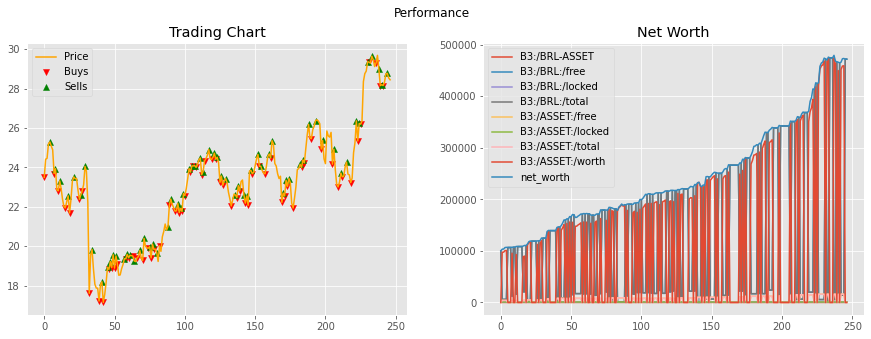

In [9]:
# Instantiate the environment
env = create_training_env({
    "window_size": window_size
})

# Run until episode ends
episode_reward = 0
done = False
obs = env.reset()

while not done:
    action = agent.compute_single_action(obs)
    obs, reward, done, info = env.step(action)
    episode_reward += reward

env.render()

---

### Validation Set (Out-of-Sampe Data)

[*********************100%***********************]  1 of 1 completed


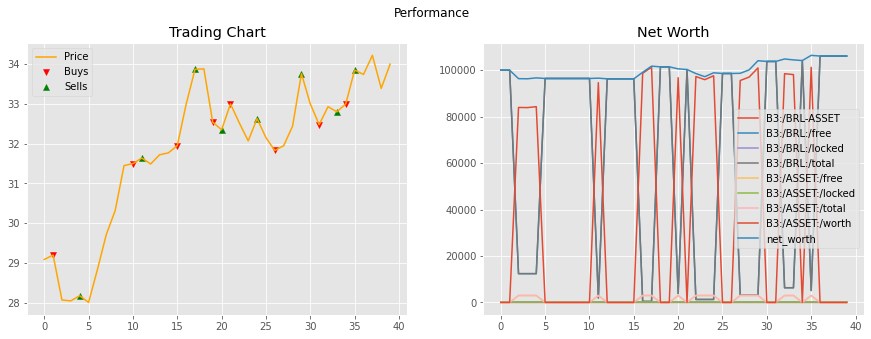

,poid,step,source,target,memo,amount,free,locked,locked_poid
0,7ca671d4-0bb9-4b4a-a351-7df546521f3d,2,B3:BRL/free,B3:BRL/locked,LOCK (LOCK FOR ORDER),87600.00 BRL,12400.00 BRL,87600.00 BRL,87600.00 BRL
1,7ca671d4-0bb9-4b4a-a351-7df546521f3d,2,B3:BRL/locked,B3,WITHDRAWAL (COMMISSION),262.80 BRL,12400.00 BRL,87337.20 BRL,87337.20 BRL
2,7ca671d4-0bb9-4b4a-a351-7df546521f3d,2,B3:BRL/locked,B3,WITHDRAWAL (FILL ORDER),87337.20 BRL,12400.00 BRL,0.00 BRL,0.00 BRL
3,7ca671d4-0bb9-4b4a-a351-7df546521f3d,2,B3,B3:ASSET/locked,DEPOSIT (TRADED 87337.20 BRL B3:BRL/ASSET @ 29...,2991.00 ASSET,0.00 ASSET,2991.00 ASSET,2991.00 ASSET
4,7ca671d4-0bb9-4b4a-a351-7df546521f3d,2,B3:BRL/locked,B3:BRL/free,UNLOCK BRL (COMPLETED),0.00 BRL,12400.00 BRL,0.00 BRL,0.00 BRL
5,7ca671d4-0bb9-4b4a-a351-7df546521f3d,2,B3:ASSET/locked,B3:ASSET/free,UNLOCK ASSET (COMPLETED),2991.00 ASSET,2991.00 ASSET,0.00 ASSET,0.00 ASSET
6,ec84d9fd-bfe1-4bf2-9958-9f3a3958292b,5,B3:ASSET/free,B3:ASSET/locked,LOCK (LOCK FOR ORDER),2991.00 ASSET,0.00 ASSET,2991.00 ASSET,2991.00 ASSET
7,ec84d9fd-bfe1-4bf2-9958-9f3a3958292b,5,B3:ASSET/locked,B3,WITHDRAWAL (COMMISSION),8.97 ASSET,0.00 ASSET,2982.03 ASSET,2982.03 ASSET
8,ec84d9fd-bfe1-4bf2-9958-9f3a3958292b,5,B3:ASSET/locked,B3,WITHDRAWAL (FILL ORDER),2982.03 ASSET,0.00 ASSET,0.00 ASSET,0.00 ASSET
9,ec84d9fd-bfe1-4bf2-9958-9f3a3958292b,5,B3,B3:BRL/locked,DEPOSIT (TRADED 2982.03 ASSET B3:BRL/ASSET @ 2...,84033.61 BRL,12400.00 BRL,84033.61 BRL,84033.61 BRL


In [10]:
def create_eval_env(config):
    y = config["y"]
    
    p = Stream.source(y, dtype="float").rename("BRL-ASSET")

    b3 = Exchange("B3", service=execute_order)(p)

    cash = Wallet(b3, 100000 * BRL)
    asset = Wallet(b3, 0 * ASSET)

    portfolio = Portfolio(BRL, [cash, asset])

    feed = DataFeed([
        p,
        p.rolling(window=10).mean().rename("fast"),
        p.rolling(window=50).mean().rename("medium"),
        p.rolling(window=100).mean().rename("slow"),
        p.log().diff().fillna(0).rename("lr")
    ])

    reward_scheme = PBR(price=p)

    action_scheme = BSH(
        cash=cash,
        asset=asset
    ).attach(reward_scheme)

    renderer_feed = DataFeed([
        Stream.source(y, dtype="float").rename("price"),
        Stream.sensor(action_scheme, lambda s: s.action, dtype="float").rename("action")
    ])

    environment = default.create(
        feed=feed,
        portfolio=portfolio,
        action_scheme=action_scheme,
        reward_scheme=reward_scheme,
        renderer_feed=renderer_feed,
        renderer=PositionChangeChart(),
        window_size=config["window_size"],
        max_allowed_loss=0.6
    )
    return environment, portfolio


# Instantiate the environment
env, portfolio = create_eval_env({
    "window_size": window_size,
    "y": yf.download(f'PETR4.SA', start='2022-01-02', end='2022-03-01')['Adj Close'].dropna().values
})

# Run until episode ends
episode_reward = 0
done = False
obs = env.reset()

while not done:
    action = agent.compute_single_action(obs)
    obs, reward, done, info = env.step(action)
    episode_reward += reward
    
env.render()

portfolio.ledger.as_frame().head(10)

---

In [11]:
pd.set_option('display.max_colwidth', None)

In [12]:
portfolio.ledger.as_frame().head(50)

,poid,step,source,target,memo,amount,free,locked,locked_poid
0,7ca671d4-0bb9-4b4a-a351-7df546521f3d,2,B3:BRL/free,B3:BRL/locked,LOCK (LOCK FOR ORDER),87600.00 BRL,12400.00 BRL,87600.00 BRL,87600.00 BRL
1,7ca671d4-0bb9-4b4a-a351-7df546521f3d,2,B3:BRL/locked,B3,WITHDRAWAL (COMMISSION),262.80 BRL,12400.00 BRL,87337.20 BRL,87337.20 BRL
2,7ca671d4-0bb9-4b4a-a351-7df546521f3d,2,B3:BRL/locked,B3,WITHDRAWAL (FILL ORDER),87337.20 BRL,12400.00 BRL,0.00 BRL,0.00 BRL
3,7ca671d4-0bb9-4b4a-a351-7df546521f3d,2,B3,B3:ASSET/locked,DEPOSIT (TRADED 87337.20 BRL B3:BRL/ASSET @ 29.20),2991.00 ASSET,0.00 ASSET,2991.00 ASSET,2991.00 ASSET
4,7ca671d4-0bb9-4b4a-a351-7df546521f3d,2,B3:BRL/locked,B3:BRL/free,UNLOCK BRL (COMPLETED),0.00 BRL,12400.00 BRL,0.00 BRL,0.00 BRL
5,7ca671d4-0bb9-4b4a-a351-7df546521f3d,2,B3:ASSET/locked,B3:ASSET/free,UNLOCK ASSET (COMPLETED),2991.00 ASSET,2991.00 ASSET,0.00 ASSET,0.00 ASSET
6,ec84d9fd-bfe1-4bf2-9958-9f3a3958292b,5,B3:ASSET/free,B3:ASSET/locked,LOCK (LOCK FOR ORDER),2991.00 ASSET,0.00 ASSET,2991.00 ASSET,2991.00 ASSET
7,ec84d9fd-bfe1-4bf2-9958-9f3a3958292b,5,B3:ASSET/locked,B3,WITHDRAWAL (COMMISSION),8.97 ASSET,0.00 ASSET,2982.03 ASSET,2982.03 ASSET
8,ec84d9fd-bfe1-4bf2-9958-9f3a3958292b,5,B3:ASSET/locked,B3,WITHDRAWAL (FILL ORDER),2982.03 ASSET,0.00 ASSET,0.00 ASSET,0.00 ASSET
9,ec84d9fd-bfe1-4bf2-9958-9f3a3958292b,5,B3,B3:BRL/locked,DEPOSIT (TRADED 2982.03 ASSET B3:BRL/ASSET @ 28.18),84033.61 BRL,12400.00 BRL,84033.61 BRL,84033.61 BRL


In [13]:
df = pd.DataFrame(portfolio.performance)

new_column_list = list(yf.download(f'PETR4.SA', start='2022-01-02', end='2022-03-01').index.astype(str).values)

assert len(new_column_list) == df.shape[1]

df.set_axis(new_column_list, axis=1, inplace=True)

[*********************100%***********************]  1 of 1 completed


In [28]:
def plot_evaluation_results(df):
    """Plot Evaluation Set Results."""
    fig, ax = plt.subplots(3, sharex=True, figsize=(15,6))
    
    # Net Worth
    df.loc["net_worth"].plot(ax=ax[0])
    ax[0].set_title('Net Worth')
    ax[0].set_ylabel("Cash (R$)")
    #ax[0].set_xlabel("Valores em X")
    ax[0].legend(['Current Net Worth'])
    
    # Asset Price
    df.loc["B3:/BRL-ASSET"].plot(ax=ax[1])
    ax[1].set_title('Asset Price')
    ax[1].set_ylabel("Price (R$)")
    ax[1].legend(['Current Share Price'])
    
    # Positions
    df.loc["B3:/ASSET:/total"].plot(ax=ax[2])
    ax[2].set_title('Positions')
    ax[2].set_ylabel("Shares (#)")
    ax[2].set_xlabel("Datetime")
    ax[2].legend(['Current Position'])
    
    plt.tight_layout()

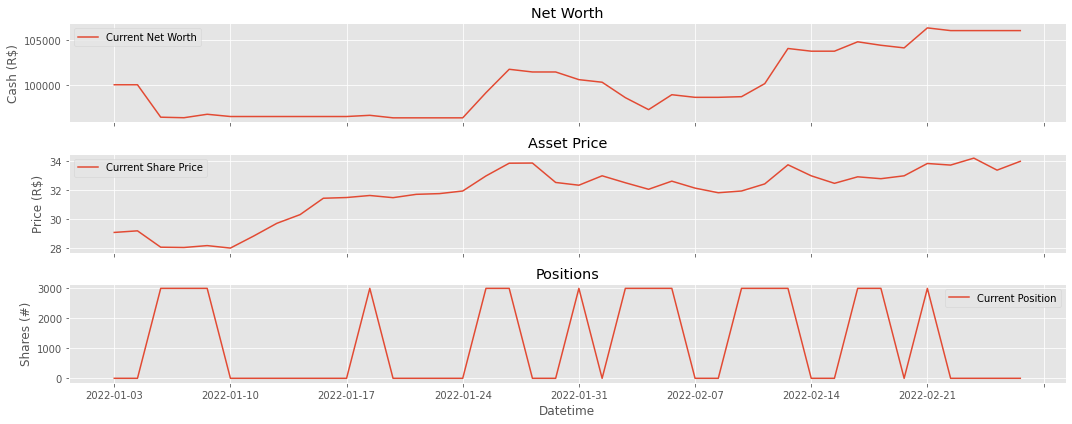

In [29]:
plot_evaluation_results(df)

---